<a href="https://colab.research.google.com/github/Tavo826/UN/blob/main/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


# Data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

from sklearn.model_selection import train_test_split

In [ ]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Xtrain:  (60000, 28, 28)
ytrain:  (60000,)
Xtest:  (10000, 28, 28)
ytest:  (10000,)
Clases:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


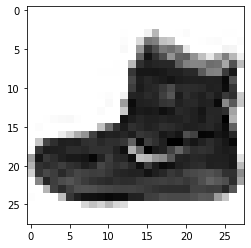

In [ ]:
print('Xtrain: ', Xtrain.shape)
print('ytrain: ', ytrain.shape)
print('Xtest: ', Xtest.shape)
print('ytest: ', ytest.shape)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


print('Clases: ', class_names)

plt.imshow(Xtrain[0], cmap='binary')

# Entradas y salidas

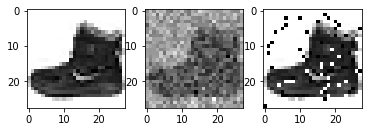

In [ ]:
#Agregando entradas con ruido 

#Ruido gaussiano
var = 0.1
Xtrain_GN = Xtrain/255 + np.sqrt(var)*np.random.randn(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2])
Xtest_GN = Xtest/255 + np.sqrt(var)*np.random.randn(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2])

#Sal y pimienta
from google.colab.patches import cv2_imshow
import cv2
def sal_pimienta(img, SNR=0.9):
    img_ = img.copy()
    c, h, w = img_.shape
    mask = np.random.choice((0, 1, 2), size=(1, h, w), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    mask = np.repeat(mask, c, axis=0)
    img_[mask == 1] = 255
    img_[mask == 2] = 0
    return img_

Xtrain_SP = sal_pimienta(Xtrain)
Xtest_SP = sal_pimienta(Xtest)

fig, ax = plt.subplots(1,3)
ax[0].imshow(Xtrain[0], cmap='binary')
ax[1].imshow(Xtrain_GN[0], cmap='binary')
ax[2].imshow(Xtrain_SP[0], cmap='binary')
plt.show()

In [ ]:
# Definiendo las salidas

# 'T-shirt/top' -> unisex (0)
# 'Trouser' -> unisex (0)
# 'Pullover' -> unisex (0)
# 'Dress' -> femenino (2)
# 'Coat' -> unisex (0)
# 'Sandal' -> femenino (2)
# 'Shirt' -> unisex (0)
# 'Sneaker' -> unisex (0)
# 'Bag' -> femenino (2)
# 'Ankle boot' -> masculino (1)

print(np.unique(ytrain))

ytrainB = np.ones((ytrain.shape[0]))
ytestB = np.ones((ytest.shape[0]))

# Masculino
ytrainB[ytrain==9] = 0
ytestB[ytest==9] = 0

# Femenino
ytrainB[ytrain==3] = 2
ytrainB[ytrain==5] = 2
ytrainB[ytrain==8] = 2

ytestB[ytest==3] = 2
ytestB[ytest==5] = 2
ytestB[ytest==8] = 2

print(np.unique(ytrainB))

[0 1 2 3 4 5 6 7 8 9]
[0. 1. 2.]


# Red Densa

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Entrada_binaria (InputLayer)    [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
Entrada_gaussiana (InputLayer)  [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
Entrada_salPim (InputLayer)     [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           Entrada_binaria[0][0]            
______________________________________________________________________________________________

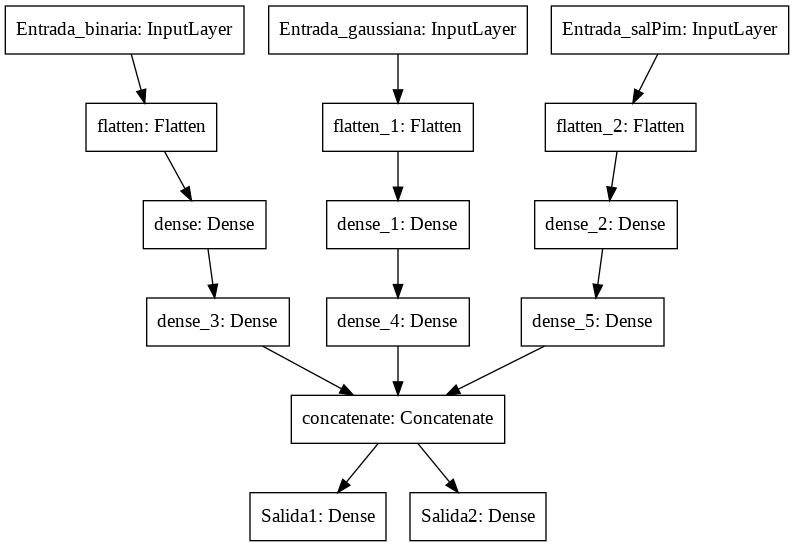

In [ ]:
Xtrain = Xtrain/255
Xtest = Xtest/255
Xtrain_SP = Xtrain_SP/255

lr = 1e-3

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='Entrada_binaria')
inputB = tf.keras.layers.Input(shape=(Xtrain_GN.shape[1],Xtrain_GN.shape[2]), name='Entrada_gaussiana')
inputC = tf.keras.layers.Input(shape=(Xtrain_SP.shape[1],Xtrain_SP.shape[2]), name='Entrada_salPim')

FA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
FB = tf.keras.layers.Flatten(input_shape=(Xtrain_GN.shape[1],Xtrain_GN.shape[2]))(inputB)
FC = tf.keras.layers.Flatten(input_shape=(Xtrain_SP.shape[1],Xtrain_SP.shape[2]))(inputC)

DA1 = tf.keras.layers.Dense(300,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(FA)
DB1 = tf.keras.layers.Dense(300,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(FB)
DC1 = tf.keras.layers.Dense(300,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(FC)

DA2 = tf.keras.layers.Dense(100,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(DA1)
DB2 = tf.keras.layers.Dense(100,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(DB1)
DC2 = tf.keras.layers.Dense(100,activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=lr,l2=lr))(DC1)

conc = tf.keras.layers.concatenate([DA2,DB2,DC2])

outputA = tf.keras.layers.Dense(10,activation="softmax",name='Salida1')(conc)
outputB = tf.keras.layers.Dense(3,activation="softmax",name='Salida2')(conc)

model = tf.keras.Model(inputs=[inputA, inputB, inputC],outputs=[outputA, outputB])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=False)

In [ ]:
model.compile(loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],
              loss_weights = [0.5,0.5],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model.fit(x =[Xtrain,Xtrain_GN,Xtrain_SP], y=[ytrain,ytrainB], 
                        epochs=30,batch_size=64,
                         validation_split=0.3)

Epoch 1/30
657/657 [==============================] - 7s 10ms/step - loss: 3.2315 - Salida1_loss: 0.7669 - Salida2_loss: 0.3194 - Salida1_accuracy: 0.7417 - Salida2_accuracy: 0.8832 - val_loss: 0.7631 - val_Salida1_loss: 0.6140 - val_Salida2_loss: 0.2365 - val_Salida1_accuracy: 0.7767 - val_Salida2_accuracy: 0.9119
Epoch 2/30
657/657 [==============================] - 6s 9ms/step - loss: 0.7109 - Salida1_loss: 0.5854 - Salida2_loss: 0.2303 - Salida1_accuracy: 0.7954 - Salida2_accuracy: 0.9149 - val_loss: 0.6553 - val_Salida1_loss: 0.5428 - val_Salida2_loss: 0.2150 - val_Salida1_accuracy: 0.8097 - val_Salida2_accuracy: 0.9197
Epoch 3/30
657/657 [==============================] - 6s 9ms/step - loss: 0.6471 - Salida1_loss: 0.5435 - Salida2_loss: 0.2114 - Salida1_accuracy: 0.8082 - Salida2_accuracy: 0.9222 - val_loss: 0.6290 - val_Salida1_loss: 0.5295 - val_Salida2_loss: 0.2055 - val_Salida1_accuracy: 0.8139 - val_Salida2_accuracy: 0.9201
Epoch 4/30
657/657 [==============================]

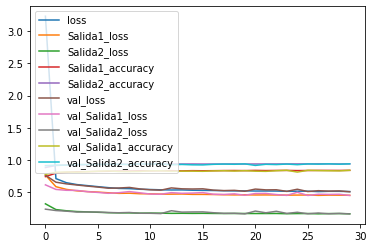

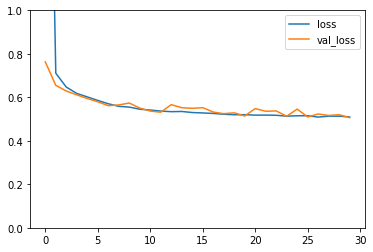

In [ ]:
import pandas as pd
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.gca().set_ylim(0,1)
plt.show()

(10000, 10)
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.99      0.94      0.96      1000
           2       0.70      0.72      0.71      1000
           3       0.79      0.88      0.84      1000
           4       0.71      0.74      0.73      1000
           5       0.90      0.94      0.92      1000
           6       0.59      0.52      0.56      1000
           7       0.89      0.94      0.91      1000
           8       0.93      0.93      0.93      1000
           9       0.97      0.89      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



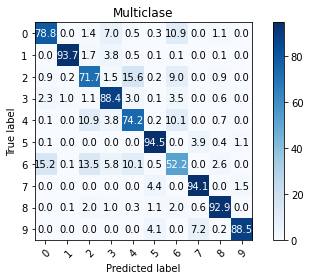

(10000, 3)
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      1000
         1.0       0.95      0.95      0.95      6000
         2.0       0.90      0.91      0.91      3000

    accuracy                           0.93     10000
   macro avg       0.94      0.92      0.93     10000
weighted avg       0.94      0.93      0.93     10000



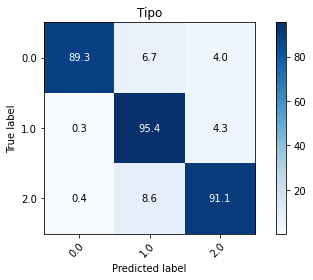

In [ ]:
ytest_e,ytest_eB = model.predict([Xtest,Xtest_GN,Xtest])
print(ytest_e.shape)
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=np.unique(ytest))
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))
plt.show()

print(ytest_eB.shape)
plot_confusion_matrix(ytestB, ytest_eB.argmax(axis=1),classes=np.unique(ytestB))
plt.title('Tipo')
print(classification_report(ytestB, ytest_eB.argmax(axis=1)))

# Red convolucional

In [ ]:
# Xtrain, Xvalid, Xtest, ytrain, yvalid

Xtrain_full = Xtrain
ytrain_full = ytrain

Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain_full, ytrain_full, test_size=0.3)

Xtrain = Xtrain[..., np.newaxis]
Xvalid = Xvalid[..., np.newaxis]
Xtest = Xtest[..., np.newaxis]

# Xtrain_GN, Xvalid_GN

Xtrain_GN_full = Xtrain_GN

Xtrain_GN, Xvalid_GN = train_test_split(Xtrain_GN_full, test_size=0.3)

Xtrain_GN = Xtrain_GN[..., np.newaxis]
Xvalid_GN = Xvalid_GN[..., np.newaxis]
Xtest_GN = Xtest_GN[..., np.newaxis]

# Xtrain_SP, Xvalid_SP

Xtrain_SP_full = Xtrain_SP

Xtrain_SP, Xvalid_SP = train_test_split(Xtrain_SP_full, test_size=0.3)

Xtrain_SP = Xtrain_SP[..., np.newaxis]
Xvalid_SP = Xvalid_SP[..., np.newaxis]
Xtest_SP = Xtest_SP[..., np.newaxis]

# ytrainB, yvalidB

ytrainB_full = ytrainB

ytrainB, yvalidB = train_test_split(ytrainB_full, test_size=0.3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1A_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1B_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1C_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1A (Conv2D)                 (None, 28, 28, 100)  1000        conv1A_input[0][0]               
____________________________________________________________________________________________

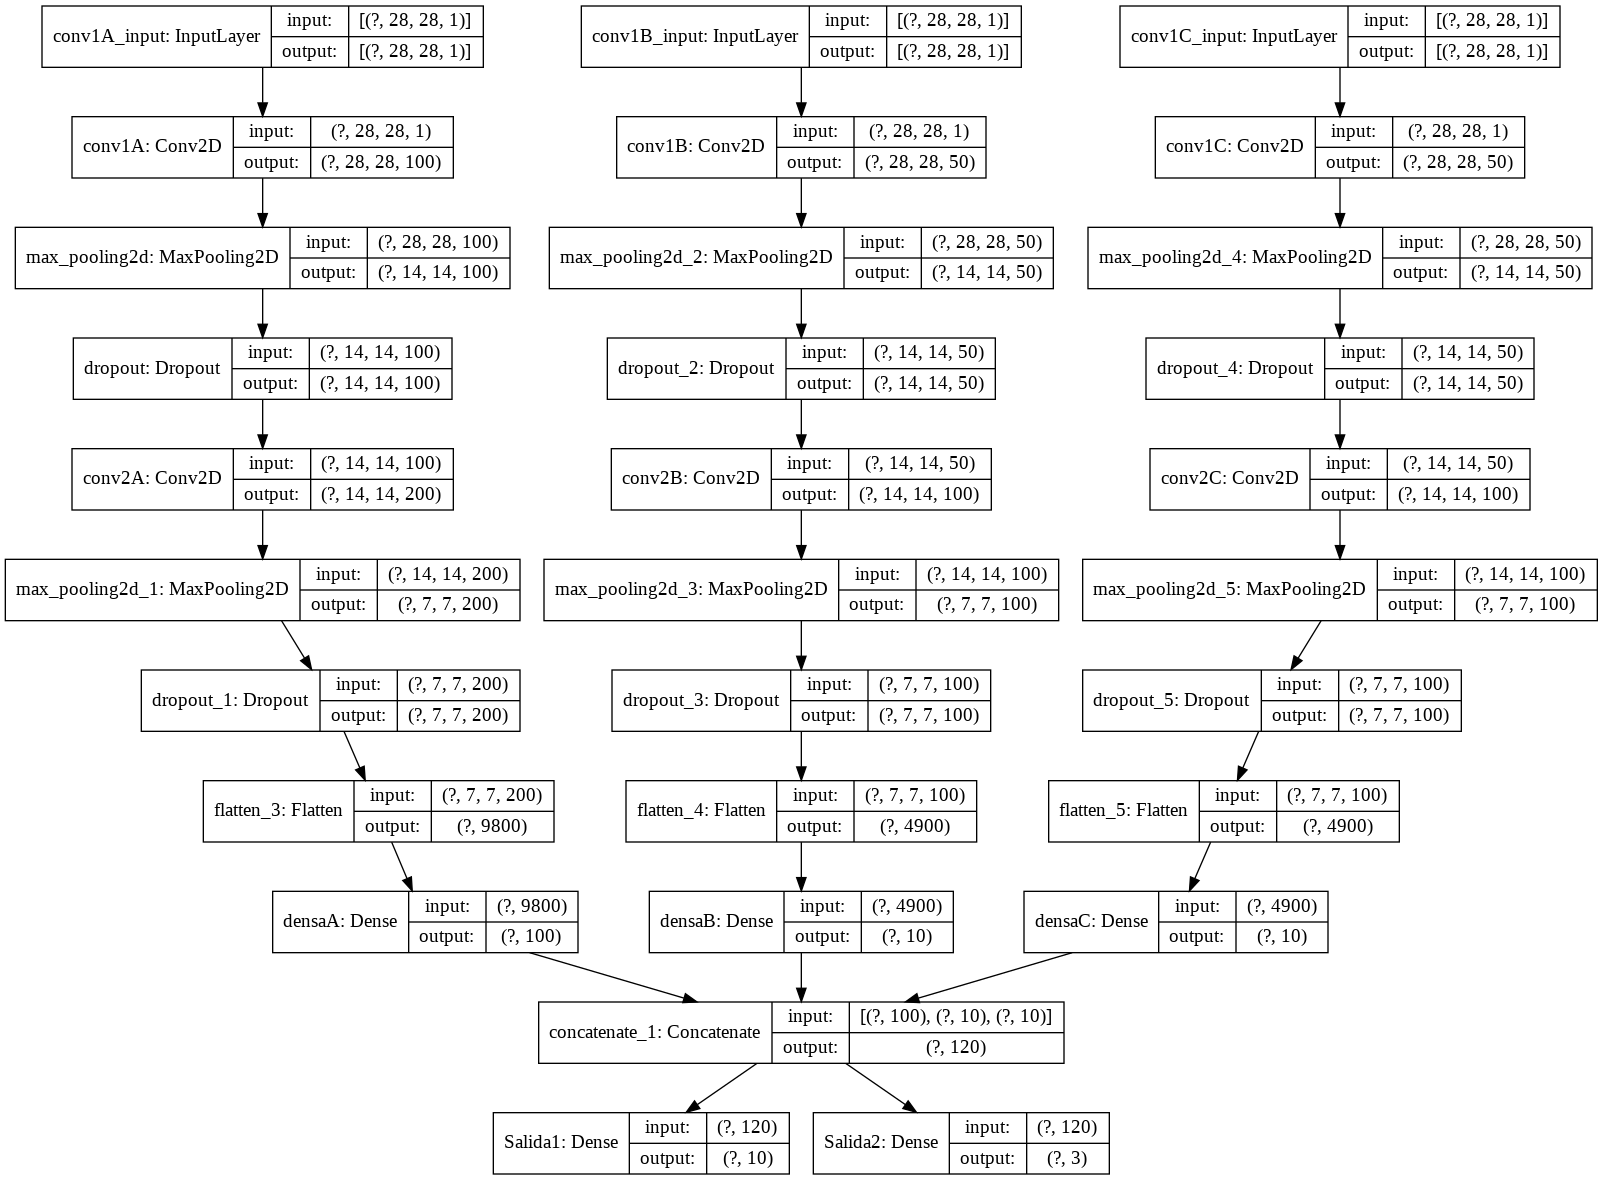

In [ ]:
# tf.keras.backend.clear_session()

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = tf.keras.models.Sequential([
    DefaultConv2D(filters=100, kernel_size=3, 
                  input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1],
                  name='conv1A'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),   
    DefaultConv2D(filters=200, kernel_size=3,
                  name='conv2A'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, 
                          activation='relu',
                          name='densaA'),
])

model_GN = tf.keras.models.Sequential([
    DefaultConv2D(filters=50, kernel_size=3, 
                  input_shape=[Xtrain_GN.shape[1], Xtrain_GN.shape[2], 1],
                  name='conv1B'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    DefaultConv2D(filters=100,
                  name='conv2B'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, 
                          activation='tanh',
                          name='densaB'),
])

model_SP = tf.keras.models.Sequential([
    DefaultConv2D(filters=50, kernel_size=3, 
                  input_shape=[Xtrain_GN.shape[1], Xtrain_GN.shape[2], 1],
                  name='conv1C'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    DefaultConv2D(filters=100,
                  name='conv2C'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, 
                          activation='tanh',
                          name='densaC'),
])

concat = tf.keras.layers.concatenate([model.output, 
                                      model_GN.output,
                                      model_SP.output])

salida1 = tf.keras.layers.Dense(10, 
                                activation='softmax', 
                                name='Salida1')(concat)

salida2 = tf.keras.layers.Dense(3, 
                                activation='softmax', 
                                name='Salida2')(concat)

model_fin = tf.keras.Model(inputs=[model.input,
                                   model_GN.input,
                                   model_SP.input],
                           outputs=[salida1, salida2])

model_fin.summary()
tf.keras.utils.plot_model(model_fin, show_shapes=True)

In [ ]:
model_fin.compile(loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
                  loss_weights = [0.7,0.3], 
                  optimizer="adam", 
                  metrics=["accuracy"])
history = model_fin.fit(x = [Xtrain, Xtrain_GN, Xtrain_SP], 
                    y = [ytrain, ytrainB], 
                    epochs=15, 
                    validation_data=([Xvalid, Xvalid_GN, Xvalid_SP], 
                                     [yvalid, yvalidB]))


Epoch 1/15
1313/1313 [==============================] - 31s 24ms/step - loss: 0.6173 - Salida1_loss: 0.4803 - Salida2_loss: 0.9368 - Salida1_accuracy: 0.8244 - Salida2_accuracy: 0.5771 - val_loss: 0.5067 - val_Salida1_loss: 0.3346 - val_Salida2_loss: 0.9083 - val_Salida1_accuracy: 0.8798 - val_Salida2_accuracy: 0.5994
Epoch 2/15
1313/1313 [==============================] - 30s 23ms/step - loss: 0.5026 - Salida1_loss: 0.3279 - Salida2_loss: 0.9103 - Salida1_accuracy: 0.8800 - Salida2_accuracy: 0.5962 - val_loss: 0.4846 - val_Salida1_loss: 0.3035 - val_Salida2_loss: 0.9072 - val_Salida1_accuracy: 0.8899 - val_Salida2_accuracy: 0.5994
Epoch 3/15
1313/1313 [==============================] - 30s 23ms/step - loss: 0.4741 - Salida1_loss: 0.2892 - Salida2_loss: 0.9056 - Salida1_accuracy: 0.8927 - Salida2_accuracy: 0.5989 - val_loss: 0.4659 - val_Salida1_loss: 0.2773 - val_Salida2_loss: 0.9061 - val_Salida1_accuracy: 0.8989 - val_Salida2_accuracy: 0.5994
Epoch 4/15
1313/1313 [==================

In [ ]:
y_pred  = model_fin.predict([Xtest, Xtest_GN, Xtest_SP])

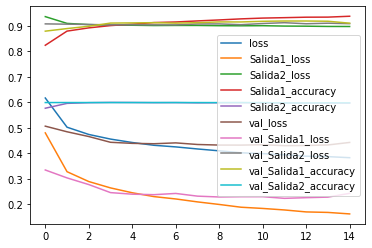

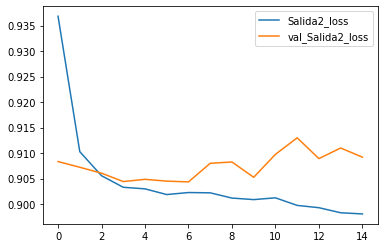

In [ ]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['Salida2_loss','val_Salida2_loss']].plot()
#plt.gca().set_ylim(0,3)
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.77      0.93      0.84      1000
           3       0.92      0.90      0.91      1000
           4       0.90      0.79      0.84      1000
           5       0.99      0.98      0.98      1000
           6       0.82      0.64      0.72      1000
           7       0.95      0.99      0.97      1000
           8       0.97      0.99      0.98      1000
           9       0.99      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



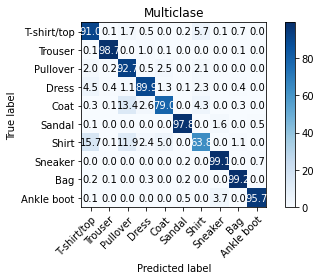

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1000
         1.0       0.60      1.00      0.75      6000
         2.0       0.14      0.00      0.01      3000

    accuracy                           0.60     10000
   macro avg       0.25      0.33      0.25     10000
weighted avg       0.40      0.60      0.45     10000



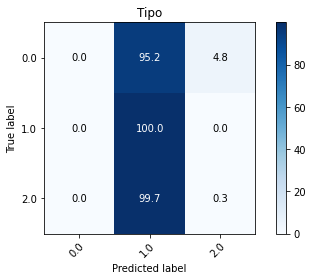

In [ ]:
ytest_e,ytest_eB = model_fin.predict([Xtest,Xtest_GN,Xtest_SP])
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=class_names)
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))
plt.show()

plot_confusion_matrix(ytestB, ytest_eB.argmax(axis=1),classes=np.unique(ytestB))
plt.title('Tipo')
print(classification_report(ytestB, ytest_eB.argmax(axis=1)))



## Analizando la red

In [ ]:
import math

def plot_conv_weights(weights, input_channel=0):
    
    w_min = np.min(weights)
    w_max = np.max(weights)

    num_filters = weights.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        
        if i<num_filters:
            
            img = weights[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [ ]:
# Model

conv1A = model.layers[0]
conv1A_w = conv1A.get_weights()[0]

conv2A = model.layers[3]
conv2A_w = conv2A.get_weights()[0]

densaA = model.layers[7]
densaA_w = abs(densaA.get_weights()[0]).sum(axis=1).reshape(100,98)

dropA = model.layers[5]

# Model_GN

conv1B = model_GN.layers[0]
conv1B_w = conv1B.get_weights()[0]

conv2B = model_GN.layers[3]
conv2B_w = conv2B.get_weights()[0]

densaB = model_GN.layers[7]
densaB_w = abs(densaB.get_weights()[0]).sum(axis=1).reshape(98,50)

dropB = model_GN.layers[5]

# Model_SP

conv1C = model_SP.layers[0]
conv1C_w = conv1C.get_weights()[0]

conv2C = model_SP.layers[3]
conv2C_w = conv2C.get_weights()[0]

densaC = model_SP.layers[7]
densaC_w = abs(densaC.get_weights()[0]).sum(axis=1).reshape(98,50)

dropC = model_SP.layers[5]

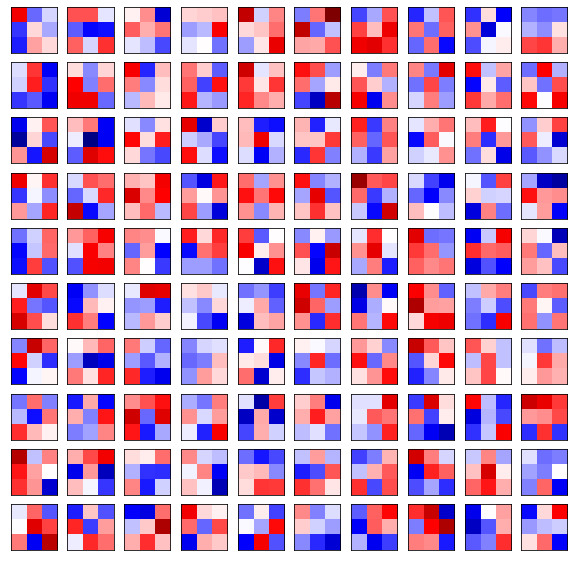

In [ ]:
plot_conv_weights(weights=conv2C_w, input_channel=0)

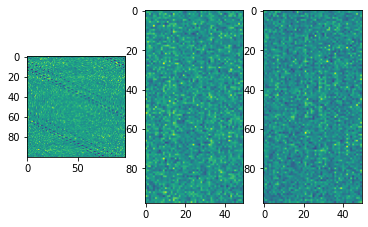

In [ ]:
densaA_w /= np.max(densaA_w)
densaB_w /= np.max(densaB_w)
densaC_w /= np.max(densaC_w)

fig, ax = plt.subplots(1,3)
ax[0].imshow(densaA_w, vmin=0, vmax=1)
ax[1].imshow(densaB_w, vmin=0, vmax=1)
ax[2].imshow(densaC_w, vmin=0, vmax=1)
plt.show()

In [ ]:
def plot_conv_output(values):

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        
        if i<num_filters:
            
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

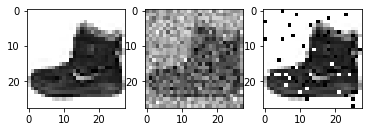

In [ ]:
(Xtrain_in, ytrain_in), (Xtest_in, ytest_in) = tf.keras.datasets.fashion_mnist.load_data()

#Ruido gaussiano
var = 0.1
Xtrain_GN_in = Xtrain_in/255 + np.sqrt(var)*np.random.randn(Xtrain_in.shape[0],Xtrain_in.shape[1],Xtrain_in.shape[2])
Xtest_GN_in = Xtest_in/255 + np.sqrt(var)*np.random.randn(Xtest_in.shape[0],Xtest_in.shape[1],Xtest_in.shape[2])

#Sal y pimienta
#from google.colab.patches import cv2_imshow
import cv2
def sal_pimienta(img, SNR=0.9):
    img_ = img.copy()
    c, h, w = img_.shape
    mask = np.random.choice((0, 1, 2), size=(1, h, w), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    mask = np.repeat(mask, c, axis=0)
    img_[mask == 1] = 255
    img_[mask == 2] = 0
    return img_

Xtrain_SP_in = sal_pimienta(Xtrain_in)
Xtest_SP_in = sal_pimienta(Xtest_in)

fig, ax = plt.subplots(1,3)
ax[0].imshow(Xtrain_in[0], cmap='binary')
ax[1].imshow(Xtrain_GN_in[0], cmap='binary')
ax[2].imshow(Xtrain_SP_in[0], cmap='binary')
plt.show()

In [ ]:
from tensorflow.python.keras.models import Model

Mconv2A_out = Model(inputs=conv1A.input,
                  outputs=conv2A.output)

conv2A_out = Mconv2A_out.predict(np.array([Xtrain[0]]))

Mdrop_outA = Model(inputs=conv1A.input,
                  outputs=dropA.output)

drop_outA = Mdrop_outA.predict(np.array([Xtrain[0]]))


Mconv2B_out = Model(inputs=conv1B.input,
                   outputs=conv2B.output)

conv2B_out = Mconv2A_out.predict(np.array([Xtrain_GN[0]]))

Mdrop_outB = Model(inputs=conv1B.input,
                  outputs=dropB.output)

drop_outB = Mdrop_outB.predict(np.array([Xtrain_GN[0]]))


Mconv2C_out = Model(inputs=conv1C.input,
                   outputs=conv2C.output)

conv2C_out = Mconv2C_out.predict(np.array([Xtrain_SP[0]]))

Mdrop_outC = Model(inputs=conv1C.input,
                  outputs=dropC.output)

drop_outC = Mdrop_outC.predict(np.array([Xtrain_SP[0]]))

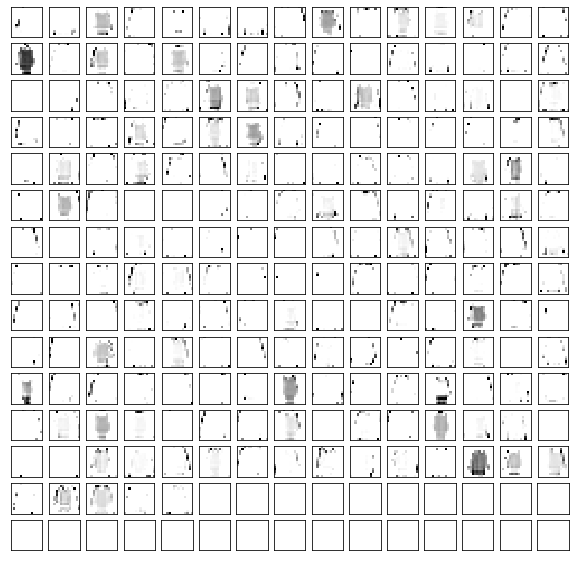

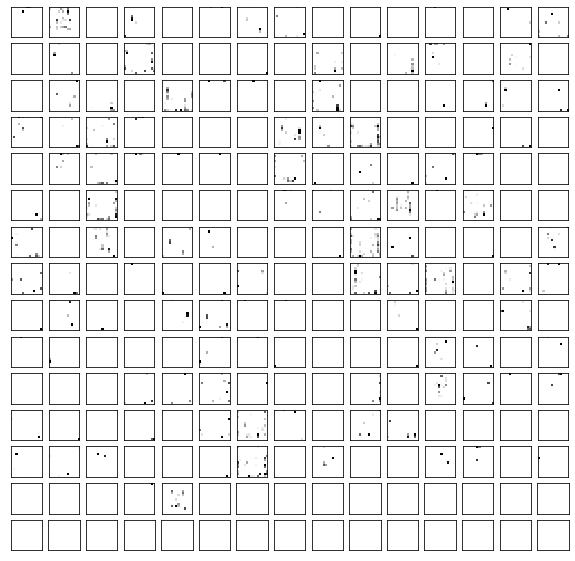

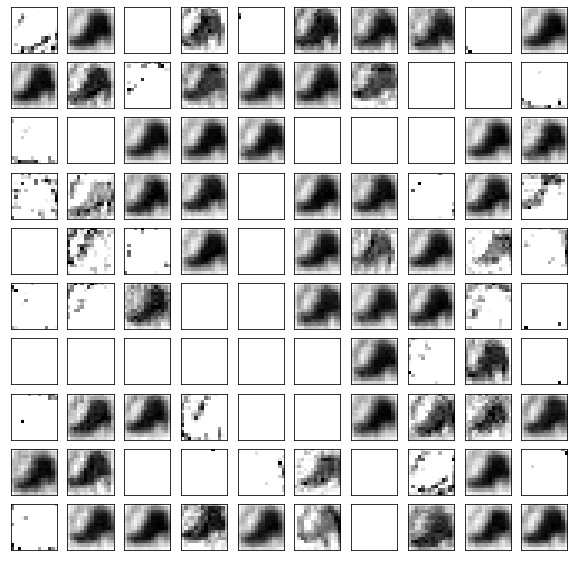

In [ ]:
plot_conv_output(values=conv2A_out)
plot_conv_output(values=conv2B_out)
plot_conv_output(values=conv2C_out)

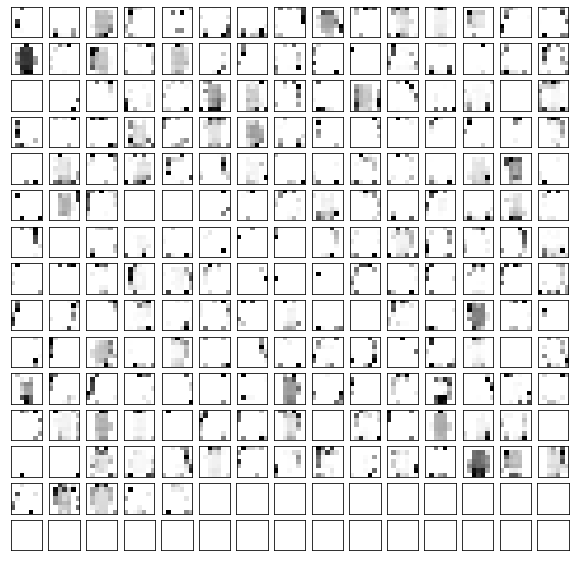

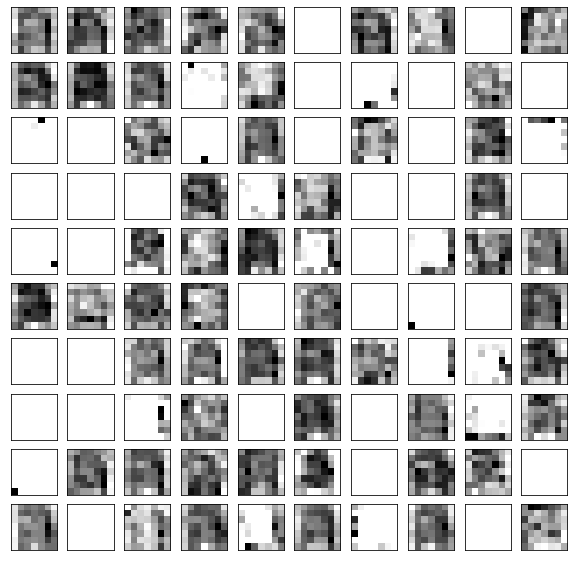

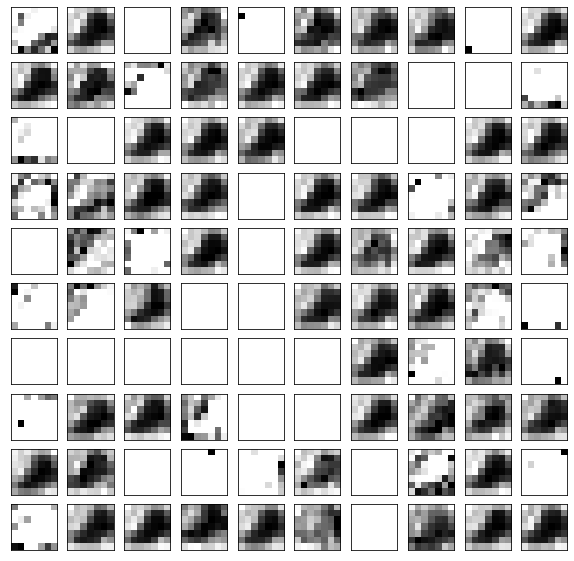

In [ ]:
plot_conv_output(values=drop_outA)
plot_conv_output(values=drop_outB)
plot_conv_output(values=drop_outC)